Số lớp biển báo: 43


e:\Users\PC\anaconda3\envs\gtsrb\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Users\PC\anaconda3\envs\gtsrb\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 1.6397
Epoch 2, Loss: 1.0857
Epoch 3, Loss: 0.9622
Epoch 4, Loss: 0.8923
Epoch 5, Loss: 0.8560
Huấn luyện xong!
              precision    recall  f1-score   support

           0       0.23      0.25      0.24        60
           1       0.60      0.47      0.52       720
           2       0.43      0.24      0.31       750
           3       0.29      0.27      0.28       450
           4       0.38      0.49      0.43       660
           5       0.28      0.61      0.38       630
           6       0.70      0.41      0.52       150
           7       0.48      0.50      0.49       450
           8       0.23      0.19      0.21       450
           9       0.69      0.44      0.54       480
          10       0.73      0.70      0.71       660
          11       0.37      0.48      0.42       420
          12       0.87      0.85      0.86       690
          13       0.88      0.87      0.87       720
          14       0.87      0.84      0.85       270
        

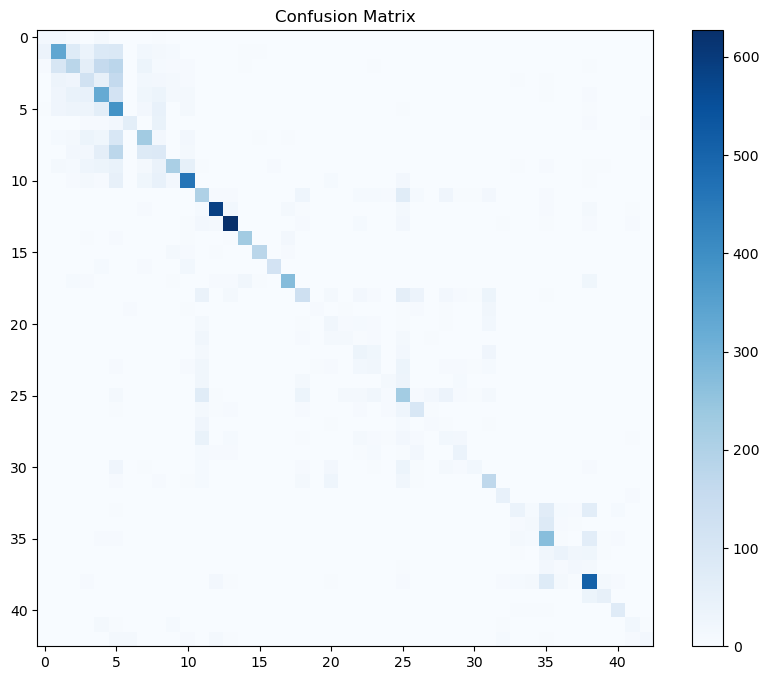

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# -------------------------
# 1. Custom Dataset for GTSRB Kaggle CSV format
# -------------------------
class GTSRBDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Path']  # Path column contains full relative path
        image = Image.open(img_name)
        label = int(self.data.iloc[idx]['ClassId'])

        if self.transform:
            image = self.transform(image)

        return image, label

# -------------------------
# 2. Transform & DataLoader
# -------------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = GTSRBDataset(
    csv_file="Train.csv", transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Nếu Test.csv có nhãn:
test_dataset = GTSRBDataset(
    csv_file="Test.csv", transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = len(pd.read_csv("Meta.csv"))
print("Số lớp biển báo:", num_classes)

# -------------------------
# 3. Transfer Learning với ResNet18
# -------------------------
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

def train_model(model, train_loader, epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    print("Huấn luyện xong!")
    return model

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

# -------------------------
# Run
# -------------------------
model = train_model(model, train_loader, epochs=5)
evaluate_model(model, test_loader)

In [4]:
torch.save(model.state_dict(), "traffic_sign_model.pth")

